# Convolutional Neural Networks
For convolutional section we’ll focus on images and the dataset will be Multi-class Weather Dataset for Image Classification used in the paper “Multi-class weather recognition from the still image using heterogeneous ensemble method”. Consists in images of 4 specific moments of the day and the main objective is to classify them to the proper moment of the day.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Carga de paquetes
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Sequential, Input
from tensorflow.keras.datasets import mnist

# One-hot encoding 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorio
data_dir = '/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset'

# Carga
datagen = ImageDataGenerator(rescale=1./255)

# Preprocesamiento de data
img_size = (224, 224)
batch_size = 36

data = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

# Se obtienen imagenes y etiquetas
images, labels = [], []
for batch in data:
    batch_images, batch_labels = batch
    images.append(batch_images)
    labels.append(batch_labels)
    if len(images) * batch_size >= data.samples:
        break

images = tf.concat(images, axis=0)
labels = tf.concat(labels, axis=0)


Found 1125 images belonging to 4 classes.


Chequeamos set de datos de imágenes y etiquetas

In [3]:
labels

<tf.Tensor: shape=(1125, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

In [4]:
images

<tf.Tensor: shape=(1125, 224, 224, 3), dtype=float32, numpy=
array([[[[0.11764707, 0.23137257, 0.34901962],
         [0.11764707, 0.23137257, 0.34901962],
         [0.11764707, 0.23137257, 0.34901962],
         ...,
         [0.30980393, 0.41176474, 0.5019608 ],
         [0.30588236, 0.40000004, 0.49411768],
         [0.32156864, 0.40784317, 0.5019608 ]],

        [[0.11764707, 0.23137257, 0.34901962],
         [0.11764707, 0.23137257, 0.34901962],
         [0.11764707, 0.23137257, 0.34901962],
         ...,
         [0.29803923, 0.40000004, 0.4901961 ],
         [0.3019608 , 0.39607847, 0.4901961 ],
         [0.30980393, 0.39607847, 0.4901961 ]],

        [[0.11764707, 0.23137257, 0.34901962],
         [0.11764707, 0.23137257, 0.34901962],
         [0.11764707, 0.23137257, 0.34901962],
         ...,
         [0.28627452, 0.38823533, 0.4784314 ],
         [0.29803923, 0.3921569 , 0.48627454],
         [0.29411766, 0.38823533, 0.48235297]],

        ...,

        [[0.16470589, 0.3450980

**Exploración de datos**

El EDA no es tan sencillo como con otros modelos. Por lo que usaremos gráficos simples que nos ayudarán a tener algunos insights.

In [5]:
import os
# define the path to the subfolders
cloudy_path = '/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Cloudy/'
shine_path = '/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Shine/'
sunrise_path = '/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Sunrise/'
rain_path = '/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Rain/'

number_classes = {
'Class_0_Cloudy': len(os.listdir(cloudy_path)),
'Class_1_Shine': len(os.listdir(shine_path)),
'Class_2_Sunrise': len(os.listdir(sunrise_path)),
'Class_3_Rain': len(os.listdir(rain_path))}


Un gráfico de barras simple para identificar rápidamente el desequilibrio de clases.

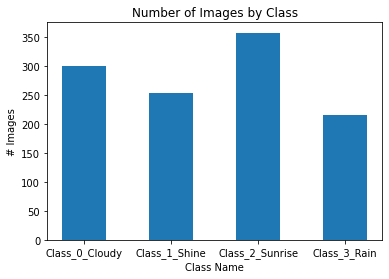

In [6]:
plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

Se observa que la clase Sunrise tiene mayor cantidad de imágenes, pero a simple vista es equilibrado. Identificar el desequilibrio de clases es un primer paso fácil. El desequilibrio en una CNN podría resultar en un rendimiento deficiente para la clase con menos representación, lo que afectaría el rendimiento general.

El tamaño de imágen consistente es crucial para deep  learning, las matrices que no coinciden harán que el proyecto se detenga rápidamente. Visualizar el tamaño de la imagen sin procesar también puede ayudar a comprender mejor el conjunto de datos. 

[########################################] | 100% Completed | 3.25 s
[                                        ] | 0% Completed | 150.06 us

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


[########################################] | 100% Completed | 2.70 s
[                                        ] | 0% Completed | 140.66 us

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


[########################################] | 100% Completed | 4.53 s
[                                        ] | 0% Completed | 171.69 us

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


[########################################] | 100% Completed | 3.01 s


/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


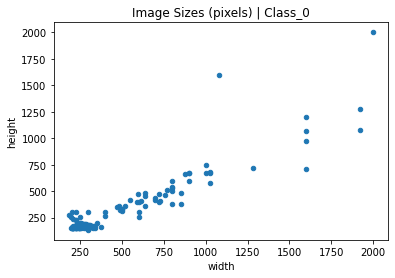

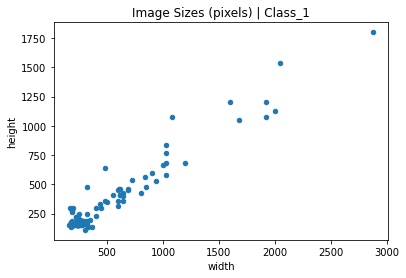

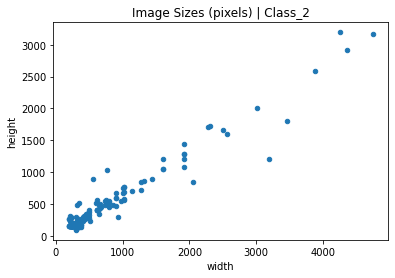

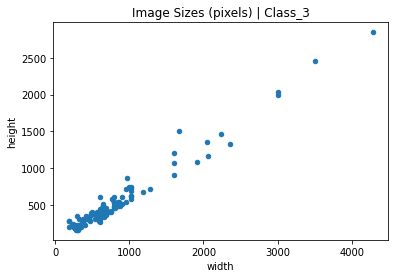

In [7]:
import os
import dask.bag as bag
import pandas as pd
from dask import diagnostics
import matplotlib.pyplot as plt
from PIL import Image

# define the path to the subfolders
cloudy_path = '/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Cloudy/'
shine_path = '/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Shine/'
sunrise_path = '/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Sunrise/'
rain_path = '/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Rain/'

directories = {'Class_0': '/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Cloudy/',
'Class_1': '/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Shine/',
'Class_2': '/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Sunrise/',
'Class_3': '/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Rain/'}

def get_dims(file):
    #Returns dimensions for an RGB image
    im = Image.open(file)
    arr = np.array(im)
    if len(arr.shape) == 2:
        # add third dimension to grayscale image
        arr = np.expand_dims(arr, axis=-1)
    h,w,d = arr.shape
    return h,w


for n,d in directories.items():
    filepath = d
    filelist = [os.path.join(filepath, f) for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)
    with diagnostics.ProgressBar():
        dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Sizes (pixels) | {}'.format(n))

Podemos ver que las imágenes tienen diferentes largos y anchos en las diferentes clases, por lo que hay bastante variación. Podemos observar que la mayoría de las imágenes caen entre 0 y 1000 píxeles.

Finalmente, vamos a ver algunas imágenes de dos de las clases: cloud y shine. Aunque esto no es crucial para el modelo en sí, ayuda a familiarizarse con los datos. Cuanto más familiarizado estemos con los datos, mejor comprenderemos los resultados del modelo, lo que permitirá iteraciones inteligentes y, en última instancia, un modelo mucho más inteligente.

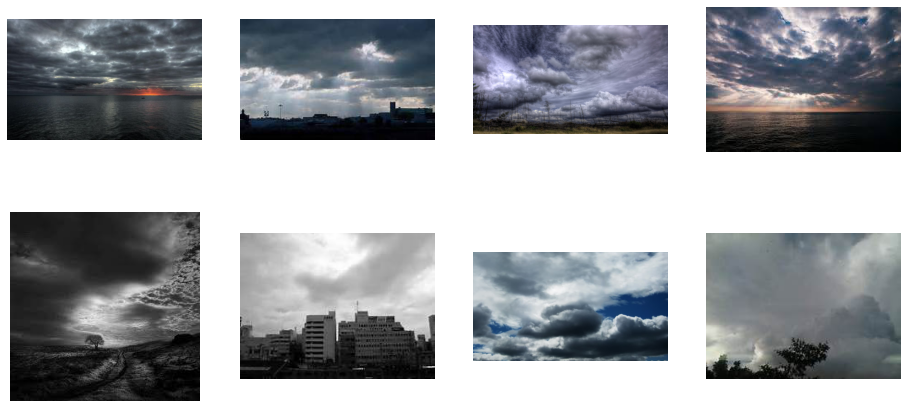

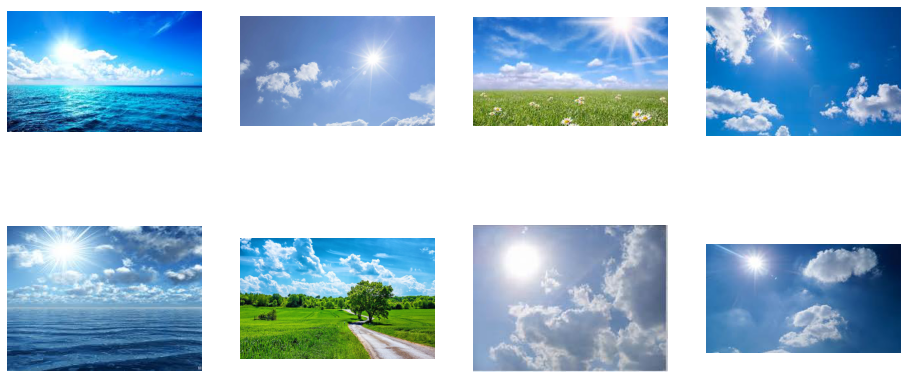

In [10]:
 import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directory with our training cloud pictures
train_cloud_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Cloudy/')

# Directory with our training shine pictures
train_shine_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/DL datasets/Multi-class Weather Dataset/Shine/')

# Find all files in the directories
cloud_files = os.listdir(train_cloud_dir)
shine_files = os.listdir(train_shine_dir)

# Select 8 random blight images
next_cloud_pix = random.sample([os.path.join(train_cloud_dir, fname) for fname in cloud_files], 8)

# Select 8 random healthy images
next_shine_pix = random.sample([os.path.join(train_shine_dir, fname) for fname in shine_files], 8)

# Define function to show sample of images
def show_image_sample(pic_directory):
    nrows = 4
    ncols = 4
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    for i, img_path in enumerate(pic_directory):
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        img = mpimg.imread(img_path)
        plt.imshow(img)
    plt.show()

# Display the images
show_image_sample(next_cloud_pix)
show_image_sample(next_shine_pix)

Como vemos arriba, una pequeña muestra de clases puede enseñarnos mucho sobre nuestro conjunto de datos. Podemos ver que las imágenes tienen diferentes tamaños y formas, variaciones en los fondos, el brillo, la orientación, etre otros que pueden ser claves en el deep learning.

**Prparación de datos**

Convertimos los dataset a arrays: para poder trabajarlos. Nota: fueron muchas horas tratando de superar un error muy simple de formato de estructuras, siendo el siguiente: Python "IndexError: only integers, slices (:), ellipsis (...), numpy.newaxis (None) and integer or boolean arrays are valid indices" ocurre cuando usamos un tipo no admitido para indexar una matriz NumPy.

In [11]:
images_valido = np.array(images)

In [12]:
images_valido

array([[[[0.11764707, 0.23137257, 0.34901962],
         [0.11764707, 0.23137257, 0.34901962],
         [0.11764707, 0.23137257, 0.34901962],
         ...,
         [0.30980393, 0.41176474, 0.5019608 ],
         [0.30588236, 0.40000004, 0.49411768],
         [0.32156864, 0.40784317, 0.5019608 ]],

        [[0.11764707, 0.23137257, 0.34901962],
         [0.11764707, 0.23137257, 0.34901962],
         [0.11764707, 0.23137257, 0.34901962],
         ...,
         [0.29803923, 0.40000004, 0.4901961 ],
         [0.3019608 , 0.39607847, 0.4901961 ],
         [0.30980393, 0.39607847, 0.4901961 ]],

        [[0.11764707, 0.23137257, 0.34901962],
         [0.11764707, 0.23137257, 0.34901962],
         [0.11764707, 0.23137257, 0.34901962],
         ...,
         [0.28627452, 0.38823533, 0.4784314 ],
         [0.29803923, 0.3921569 , 0.48627454],
         [0.29411766, 0.38823533, 0.48235297]],

        ...,

        [[0.16470589, 0.34509805, 0.4784314 ],
         [0.16862746, 0.34901962, 0.48235297]

In [13]:
labels_valido = np.array(labels)

In [14]:
labels_valido

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

Procedemos a separar en train and test

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images_valido, labels_valido, test_size=0.2, random_state=42)

In [16]:
print("X_train:", len(X_train))
print("X_test:", len(X_test))
print("y_train:", len(y_train))
print("y_test:", len(y_test))

X_train: 900
X_test: 225
y_train: 900
y_test: 225


Todo listo para probar modelos.

## CNN model

### Model 1

In [17]:
model = Sequential(
    [
        Input(shape=(224, 224, 3)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)

# Optimizer + compile
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

# loss: binary_crossentropy or categorical_crossentropy?
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 197136)            0         
                                                                 
 dropout (Dropout)           (None, 197136)            0         
                                                                 
 dense (Dense)               (None, 4)                 788548    
                                                                 
Total params: 788,996
Trainable params: 788,996
Non-trainable params: 0
__________________________________________________

Epoch 1/20
8/8 [==============================] - 12s 211ms/step - loss: 1.3360 - accuracy: 0.3733 - val_loss: 1.2350 - val_accuracy: 0.5289
Epoch 2/20
8/8 [==============================] - 2s 195ms/step - loss: 1.2352 - accuracy: 0.5056 - val_loss: 1.1565 - val_accuracy: 0.6756
Epoch 3/20
8/8 [==============================] - 1s 131ms/step - loss: 1.1738 - accuracy: 0.5311 - val_loss: 1.0997 - val_accuracy: 0.7022
Epoch 4/20
8/8 [==============================] - 1s 95ms/step - loss: 1.1117 - accuracy: 0.6078 - val_loss: 1.0338 - val_accuracy: 0.7022
Epoch 5/20
8/8 [==============================] - 1s 83ms/step - loss: 1.0610 - accuracy: 0.6422 - val_loss: 0.9808 - val_accuracy: 0.7289
Epoch 6/20
8/8 [==============================] - 1s 84ms/step - loss: 1.0177 - accuracy: 0.6700 - val_loss: 0.9459 - val_accuracy: 0.6756
Epoch 7/20
8/8 [==============================] - 1s 80ms/step - loss: 0.9867 - accuracy: 0.6667 - val_loss: 0.9081 - val_accuracy: 0.6978
Epoch 8/20
8/8 [=======

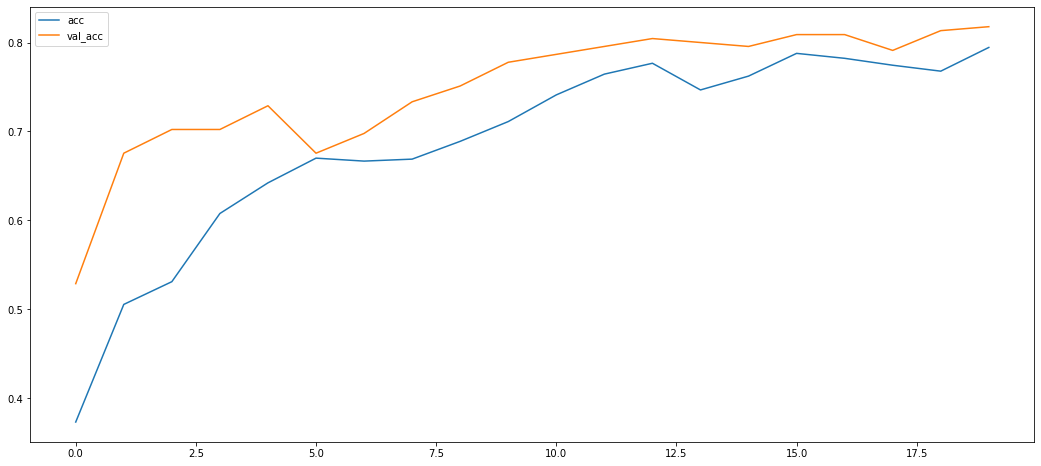

In [20]:
# Train the model, history will allow use to evaluate results
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 128, epochs = 20)


plt.figure(figsize = (18, 8))
#plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

El rendimiento del modelo mejora durante el transcurso del entrenamiento. La pérdida de validación y la precisión también muestran una tendencia de mejora.

8/8 [==============================] - 0s 12ms/step


<Axes: >

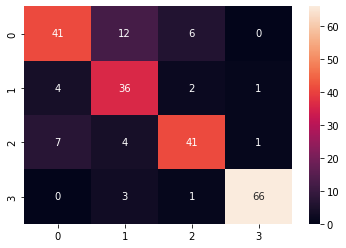

In [29]:
predicted = model.predict(X_test)
predictedClass = [np.argmax(p) for p in predicted]
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = np.argmax(y_test, axis=1)  # Convert MLI format to multiclass format
conf_mat = confusion_matrix(y_true, predictedClass)
sns.heatmap(conf_mat, annot=True)

In [31]:
# Precisión
accuracy = np.trace(conf_mat) / np.sum(conf_mat)

# Sensibilidad
sensitivity = conf_mat.diagonal() / np.sum(conf_mat, axis=1)

# Especificidad
num_classes = conf_mat.shape[0]
tmp_matrix = np.ones((num_classes, num_classes)) - np.eye(num_classes)
specificity = []
for i in range(num_classes):
    tn = np.sum(conf_mat[tmp_matrix[i] == 1])  # True negatives
    fp = np.sum(conf_mat[:, i]) - conf_mat[i, i]  # False positives
    specificity.append(tn / (tn + fp))

# F1-score
beta = 1
f1_score = (1 + beta ** 2) * sensitivity * specificity / (beta ** 2 * specificity + sensitivity)

# Imprimir resultados
print(f"Matriz de confusión:\n{conf_mat}")
print(f"Precisión: {accuracy:.4f}")
print(f"Sensibilidad: {sensitivity}")
print(f"Especificidad: {specificity}")
print(f"F1-score: {f1_score}")

Matriz de confusión:
[[41 12  6  0]
 [ 4 36  2  1]
 [ 7  4 41  1]
 [ 0  3  1 66]]
Precisión: 0.8178
Sensibilidad: [0.69491525 0.8372093  0.77358491 0.94285714]
Especificidad: [0.9378531073446328, 0.9054726368159204, 0.9502762430939227, 0.9872611464968153]
F1-score: [0.79831095 0.87000398 0.85287537 0.96454837]


En cuanto a la matriz de confusión:
Las filas de la matriz representan las clases predichas de las clases y las columnas representan las verdaderas clases de los asteroides.

Se predijo 41 muestras en la clase 0, 36 en la 1, 42 en la 2 y 66 en la 3. 

La matriz de confusión indica que el modelo clasificó correctamente 184 observaciones y clasificó incorrectamente 37 observaciones. La precisión del modelo es del 81.78%, lo que significa que el modelo clasificó correctamente el 81.78% de las observaciones.

La sensibilidad indica la capacidad del modelo para identificar correctamente una clase en particular. En este caso, la sensibilidad es mayor para la clase 3 (94.29%), lo que indica que el modelo es bueno para identificar esta clase. La sensibilidad es menor para la clase 1 (69.49%), lo que indica que el modelo tiene cierta dificultad para identificar esta clase.

El F1-score es una medida de la precisión del modelo, que considera tanto la precisión como la sensibilidad. En este caso, el F1-score es alto para todas las clases, lo que indica que el modelo es bueno para identificar todas las clases.

Aparentemente el modelo está haciendo un trabajo bueno/aceptable en la predicción de las clases. El modelo podría tener dificultades para clasificar correctamente ciertas clases, ó simplemente le falta entrenamiento. Lo veremos en un segundo modelo incrementando el número de epochs.

### Model 2

In [32]:
model = Sequential(
    [
        Input(shape=(224, 224, 3)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)

# Optimizer + compile
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

# loss: binary_crossentropy or categorical_crossentropy?
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 197136)            0         
                                                                 
 dropout_1 (Dropout)         (None, 197136)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 788548    
                                                                 
Total params: 788,996
Trainable params: 788,996
Non-trainable params: 0
________________________________________________

Epoch 1/30
8/8 [==============================] - 2s 137ms/step - loss: 1.3639 - accuracy: 0.3356 - val_loss: 1.1400 - val_accuracy: 0.6489
Epoch 2/30
8/8 [==============================] - 1s 83ms/step - loss: 1.1503 - accuracy: 0.4933 - val_loss: 0.9996 - val_accuracy: 0.6933
Epoch 3/30
8/8 [==============================] - 1s 80ms/step - loss: 1.0442 - accuracy: 0.5656 - val_loss: 0.9316 - val_accuracy: 0.7022
Epoch 4/30
8/8 [==============================] - 1s 82ms/step - loss: 0.9503 - accuracy: 0.6267 - val_loss: 0.8471 - val_accuracy: 0.7378
Epoch 5/30
8/8 [==============================] - 1s 80ms/step - loss: 0.8758 - accuracy: 0.6622 - val_loss: 0.7987 - val_accuracy: 0.7733
Epoch 6/30
8/8 [==============================] - 1s 79ms/step - loss: 0.8354 - accuracy: 0.7056 - val_loss: 0.7675 - val_accuracy: 0.7378
Epoch 7/30
8/8 [==============================] - 1s 83ms/step - loss: 0.8213 - accuracy: 0.6789 - val_loss: 0.7445 - val_accuracy: 0.7733
Epoch 8/30
8/8 [==========

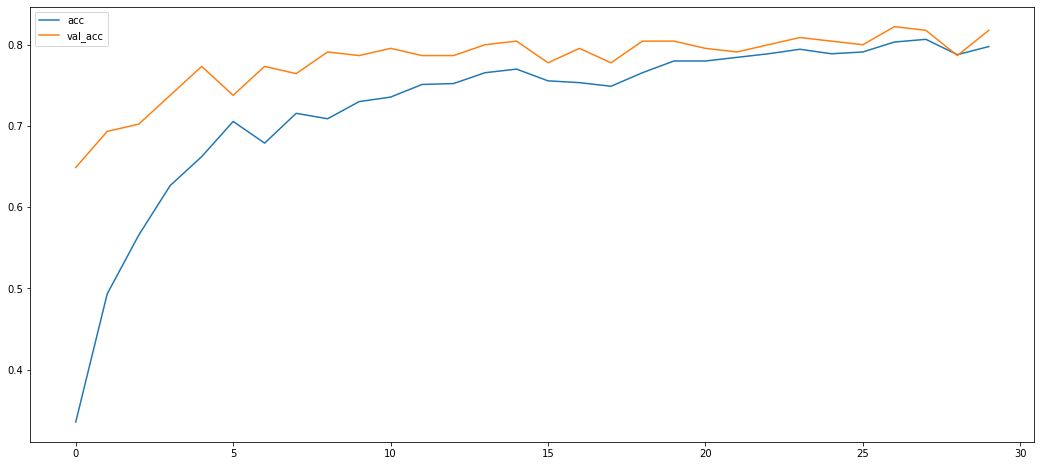

In [34]:
# Train the model, history will allow use to evaluate results
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 128, epochs = 30)


plt.figure(figsize = (18, 8))
#plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

El rendimiento del modelo mejora durante el transcurso del entrenamiento, sin mebargo no parece seguir convergiendo. Veremos con epochs = 40, en el siguiente modelo.

8/8 [==============================] - 0s 15ms/step


<Axes: >

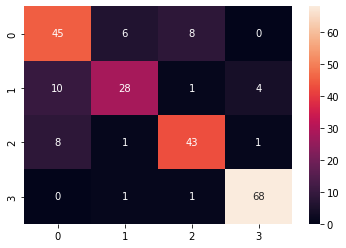

In [35]:
predicted = model.predict(X_test)
predictedClass = [np.argmax(p) for p in predicted]
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = np.argmax(y_test, axis=1)  # Convert MLI format to multiclass format
conf_mat = confusion_matrix(y_true, predictedClass)
sns.heatmap(conf_mat, annot=True)

In [36]:
# Precisión
accuracy = np.trace(conf_mat) / np.sum(conf_mat)

# Sensibilidad
sensitivity = conf_mat.diagonal() / np.sum(conf_mat, axis=1)

# Especificidad
num_classes = conf_mat.shape[0]
tmp_matrix = np.ones((num_classes, num_classes)) - np.eye(num_classes)
specificity = []
for i in range(num_classes):
    tn = np.sum(conf_mat[tmp_matrix[i] == 1])  # True negatives
    fp = np.sum(conf_mat[:, i]) - conf_mat[i, i]  # False positives
    specificity.append(tn / (tn + fp))

# F1-score
beta = 1
f1_score = (1 + beta ** 2) * sensitivity * specificity / (beta ** 2 * specificity + sensitivity)

# Imprimir resultados
print(f"Matriz de confusión:\n{conf_mat}")
print(f"Precisión: {accuracy:.4f}")
print(f"Sensibilidad: {sensitivity}")
print(f"Especificidad: {specificity}")
print(f"F1-score: {f1_score}")

Matriz de confusión:
[[45  6  8  0]
 [10 28  1  4]
 [ 8  1 43  1]
 [ 0  1  1 68]]
Precisión: 0.8178
Sensibilidad: [0.76271186 0.65116279 0.81132075 0.97142857]
Especificidad: [0.9021739130434783, 0.9578947368421052, 0.945054945054945, 0.96875]
F1-score: [0.82660175 0.77529286 0.87309645 0.97008744]


En cuanto a la matriz de confusión:
Las filas de la matriz representan las clases predichas de las clases y las columnas representan las verdaderas clases de los asteroides.

Se predijo 45 muestras en la clase 0, 28 en la 1, 43 en la 2 y 68 en la 3. 

La precisión del modelo es del 81.78%, lo que significa que el modelo clasificó correctamente el 81.78% de las observaciones.

La sensibilidad indica la capacidad del modelo para identificar correctamente una clase en particular. En este caso, la sensibilidad es mayor para la clase 4 (97.14%), lo que indica que el modelo es bueno para identificar esta clase. La sensibilidad es menor para la clase 1 (65.11%), lo que indica que el modelo tiene cierta dificultad para identificar esta clase.

El F1-score es una medida de la precisión del modelo, que considera tanto la precisión como la sensibilidad. En este caso, el F1-score es alto para todas las clases, lo que indica que el modelo es bueno para identificar todas las clases.

Aparentemente el modelo está haciendo un trabajo aceptable en la predicción de las clases. El modelo podría tener dificultades para clasificar correctamente ciertas clases, ó simplemente le falta entrenamiento. Lo veremos en un tercer modelo cambiando el size del kernel a 5, 5, paquetes de 512 y con más capas debido a la complejidad de las imágenes.

### Model 3

In [40]:
model = models.Sequential()

model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))   # Down-samples the feature space
model.add(tf.keras.layers.Conv2D(16, (5,5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 8)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 107, 107, 16)      3216      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 53, 53, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 44944)             0         
                                                                 
 dropout_3 (Dropout)         (None, 44944)            

Epoch 1/15
2/2 [==============================] - 7s 3s/step - loss: 1.4196 - accuracy: 0.2589 - val_loss: 1.3633 - val_accuracy: 0.3556
Epoch 2/15
2/2 [==============================] - 1s 355ms/step - loss: 1.3725 - accuracy: 0.3211 - val_loss: 1.3138 - val_accuracy: 0.5022
Epoch 3/15
2/2 [==============================] - 1s 359ms/step - loss: 1.3129 - accuracy: 0.4400 - val_loss: 1.2621 - val_accuracy: 0.5200
Epoch 4/15
2/2 [==============================] - 1s 351ms/step - loss: 1.2783 - accuracy: 0.4711 - val_loss: 1.1933 - val_accuracy: 0.5289
Epoch 5/15
2/2 [==============================] - 1s 357ms/step - loss: 1.2136 - accuracy: 0.5322 - val_loss: 1.1107 - val_accuracy: 0.6267
Epoch 6/15
2/2 [==============================] - 1s 360ms/step - loss: 1.1386 - accuracy: 0.5644 - val_loss: 1.0203 - val_accuracy: 0.6844
Epoch 7/15
2/2 [==============================] - 1s 364ms/step - loss: 1.0560 - accuracy: 0.6011 - val_loss: 0.9335 - val_accuracy: 0.6889
Epoch 8/15
2/2 [=======

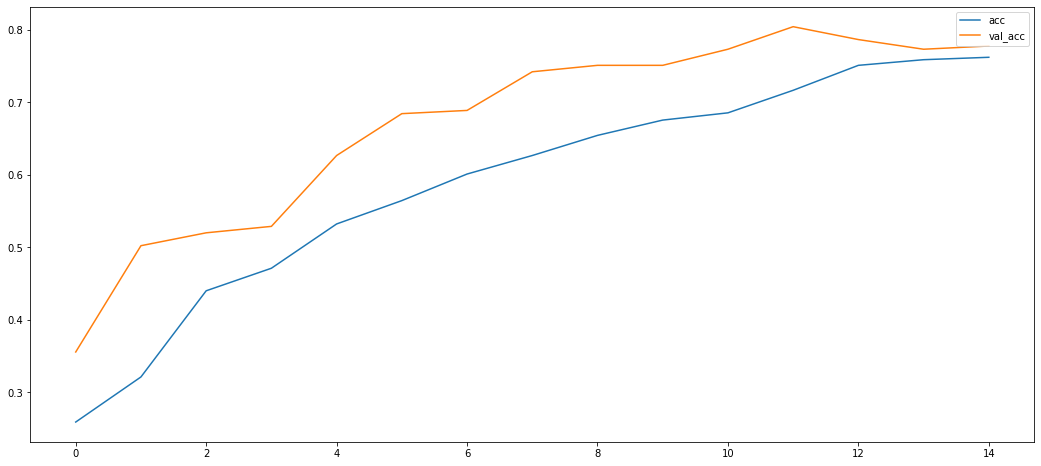

In [42]:
# Train the model, history will allow use to evaluate results
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 512, epochs = 15)


plt.figure(figsize = (18, 8))
#plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

El rendimiento del modelo mejora durante el transcurso del entrenamiento pero no es tan bueno como quisiéramos. Vamos a probar un cuarto modelo con el optimizador Adam, aumentaremos el número de epochs y el learning rate .

### Model 4

In [44]:
model = models.Sequential()

model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))   # Down-samples the feature space
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 46656)             0         
                                                                 
 dropout_5 (Dropout)         (None, 46656)            

Epoch 1/25
2/2 [==============================] - 5s 2s/step - loss: 70.0045 - accuracy: 0.2733 - val_loss: 310.6391 - val_accuracy: 0.2356
Epoch 2/25
2/2 [==============================] - 1s 540ms/step - loss: 208.7450 - accuracy: 0.1978 - val_loss: 23.8600 - val_accuracy: 0.3111
Epoch 3/25
2/2 [==============================] - 1s 376ms/step - loss: 33.6426 - accuracy: 0.2878 - val_loss: 9.6245 - val_accuracy: 0.1911
Epoch 4/25
2/2 [==============================] - 1s 356ms/step - loss: 6.8293 - accuracy: 0.3533 - val_loss: 0.9931 - val_accuracy: 0.5378
Epoch 5/25
2/2 [==============================] - 1s 361ms/step - loss: 1.5370 - accuracy: 0.4489 - val_loss: 1.0073 - val_accuracy: 0.5378
Epoch 6/25
2/2 [==============================] - 1s 366ms/step - loss: 1.0583 - accuracy: 0.5311 - val_loss: 1.0228 - val_accuracy: 0.5156
Epoch 7/25
2/2 [==============================] - 1s 359ms/step - loss: 1.0611 - accuracy: 0.5300 - val_loss: 1.0409 - val_accuracy: 0.4933
Epoch 8/25
2/2 [

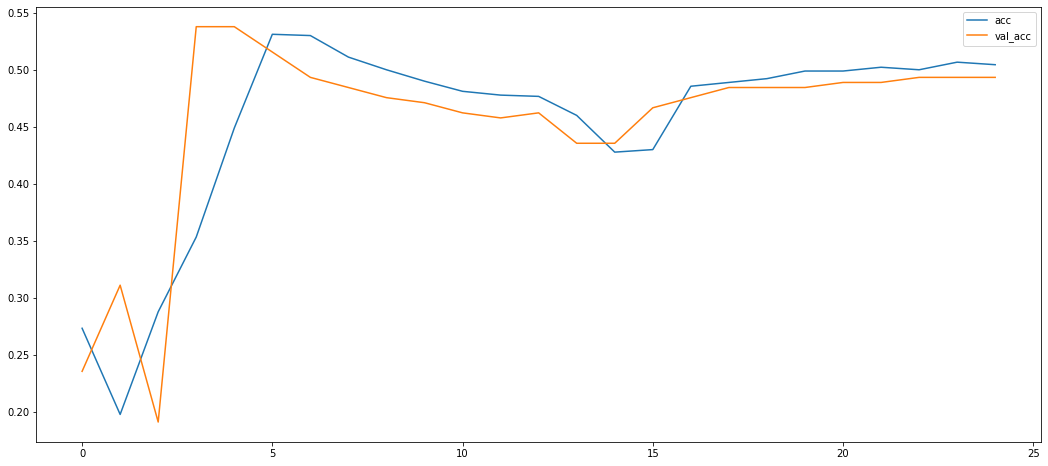

In [46]:
# Train the model, history will allow use to evaluate results
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 512, epochs = 25)


plt.figure(figsize = (18, 8))
#plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

Este es el peor modelo ya que la precisión no llega al 55%. Intentaremos con un quinto modelo a ver si mejora.

### Model 5

In [47]:
model = models.Sequential()

model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))   # Down-samples the feature space
model.add(tf.keras.layers.Conv2D(16, (5,5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(8, (5,5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 107, 107, 16)      3216      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 53, 53, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 49, 49, 8)         3208      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 8)       

Epoch 1/30
8/8 [==============================] - 4s 183ms/step - loss: 1.1379 - accuracy: 0.3911 - val_loss: 0.9201 - val_accuracy: 0.6044
Epoch 2/30
8/8 [==============================] - 1s 84ms/step - loss: 0.8730 - accuracy: 0.5933 - val_loss: 0.7455 - val_accuracy: 0.6089
Epoch 3/30
8/8 [==============================] - 1s 86ms/step - loss: 0.7724 - accuracy: 0.6389 - val_loss: 0.5794 - val_accuracy: 0.7600
Epoch 4/30
8/8 [==============================] - 1s 86ms/step - loss: 0.6874 - accuracy: 0.7100 - val_loss: 0.6555 - val_accuracy: 0.7244
Epoch 5/30
8/8 [==============================] - 1s 87ms/step - loss: 0.6331 - accuracy: 0.7267 - val_loss: 0.5382 - val_accuracy: 0.7422
Epoch 6/30
8/8 [==============================] - 1s 82ms/step - loss: 0.5684 - accuracy: 0.7822 - val_loss: 0.6126 - val_accuracy: 0.7467
Epoch 7/30
8/8 [==============================] - 1s 86ms/step - loss: 0.5699 - accuracy: 0.7633 - val_loss: 0.4606 - val_accuracy: 0.8178
Epoch 8/30
8/8 [==========

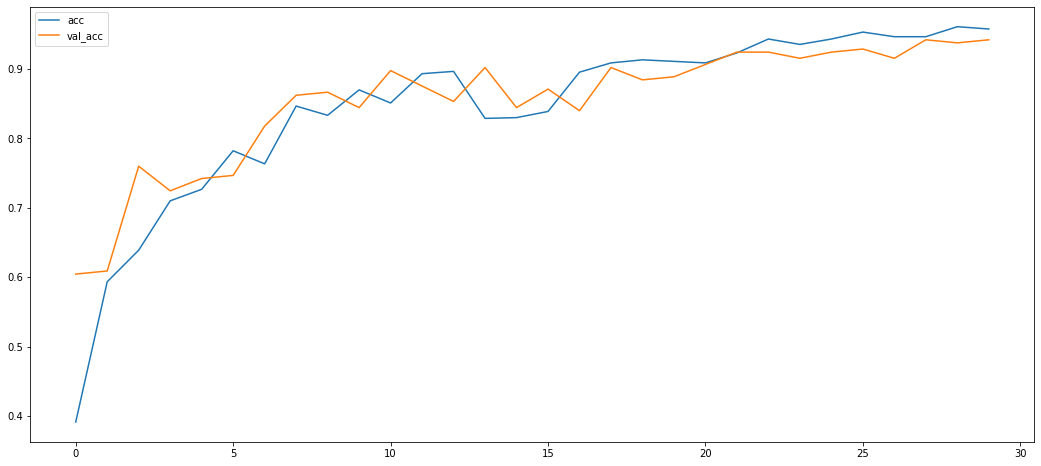

In [49]:
# Train the model, history will allow use to evaluate results
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 128, epochs = 30)


plt.figure(figsize = (18, 8))
#plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

Un modelo mejorado en accuracy, incrementaremos el número de epochs

Epoch 1/40
8/8 [==============================] - 1s 123ms/step - loss: 0.0234 - accuracy: 0.9933 - val_loss: 0.3314 - val_accuracy: 0.9511
Epoch 2/40
8/8 [==============================] - 1s 86ms/step - loss: 0.0241 - accuracy: 0.9889 - val_loss: 0.4791 - val_accuracy: 0.8978
Epoch 3/40
8/8 [==============================] - 1s 88ms/step - loss: 0.0391 - accuracy: 0.9889 - val_loss: 0.3526 - val_accuracy: 0.9289
Epoch 4/40
8/8 [==============================] - 1s 86ms/step - loss: 0.0281 - accuracy: 0.9878 - val_loss: 0.2979 - val_accuracy: 0.9378
Epoch 5/40
8/8 [==============================] - 1s 84ms/step - loss: 0.2073 - accuracy: 0.9233 - val_loss: 0.8640 - val_accuracy: 0.8000
Epoch 6/40
8/8 [==============================] - 1s 124ms/step - loss: 0.1310 - accuracy: 0.9422 - val_loss: 0.4584 - val_accuracy: 0.8889
Epoch 7/40
8/8 [==============================] - 1s 107ms/step - loss: 0.0564 - accuracy: 0.9822 - val_loss: 0.3234 - val_accuracy: 0.9022
Epoch 8/40
8/8 [========

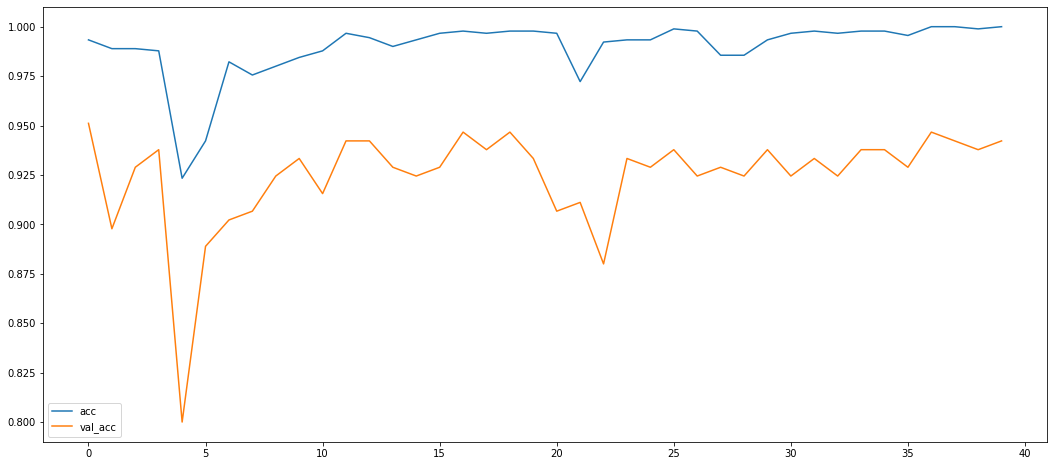

In [51]:
# Train the model, history will allow use to evaluate results
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 128, epochs = 40)


plt.figure(figsize = (18, 8))
#plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

Vemos que el modelo, en la primera epoch, la precisión en el conjunto de entrenamiento es alta (0.9933), mientras que la pérdida es baja (0.0234). Sin embargo, la precisión en el conjunto de validación es menor (0.9511) y la pérdida es mayor (0.3314). Pareciera que el modelo se está sobreajustando, ya que la precisión en el conjunto de entrenamiento es mucho mayor que en el conjunto de validación.

A lo largo de las 40 epochs, la precisión en el conjunto de entrenamiento se mantiene alta, pero la precisión en el conjunto de validación fluctúa y es más baja en general. Además, la pérdida en el conjunto de validación es alta en algunas épocas, quizás el modelo no está generalizando bien. Probaremos un último modelo, sacando capa.

### Model 6

In [52]:
model = models.Sequential()

model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))   # Down-samples the feature space
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 111, 111, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 54, 54, 16)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 46656)             0         
                                                                 
 dropout_7 (Dropout)         (None, 46656)            

Epoch 1/35
8/8 [==============================] - 3s 163ms/step - loss: 1.2285 - accuracy: 0.4778 - val_loss: 0.7699 - val_accuracy: 0.7333
Epoch 2/35
8/8 [==============================] - 1s 80ms/step - loss: 0.7224 - accuracy: 0.7667 - val_loss: 0.5511 - val_accuracy: 0.8222
Epoch 3/35
8/8 [==============================] - 1s 79ms/step - loss: 0.6267 - accuracy: 0.7789 - val_loss: 0.6506 - val_accuracy: 0.7644
Epoch 4/35
8/8 [==============================] - 1s 79ms/step - loss: 0.6592 - accuracy: 0.7633 - val_loss: 0.5790 - val_accuracy: 0.7689
Epoch 5/35
8/8 [==============================] - 1s 84ms/step - loss: 0.5338 - accuracy: 0.8156 - val_loss: 0.4665 - val_accuracy: 0.8578
Epoch 6/35
8/8 [==============================] - 1s 81ms/step - loss: 0.4607 - accuracy: 0.8522 - val_loss: 0.4972 - val_accuracy: 0.8089
Epoch 7/35
8/8 [==============================] - 1s 78ms/step - loss: 0.4237 - accuracy: 0.8489 - val_loss: 0.3728 - val_accuracy: 0.8444
Epoch 8/35
8/8 [==========

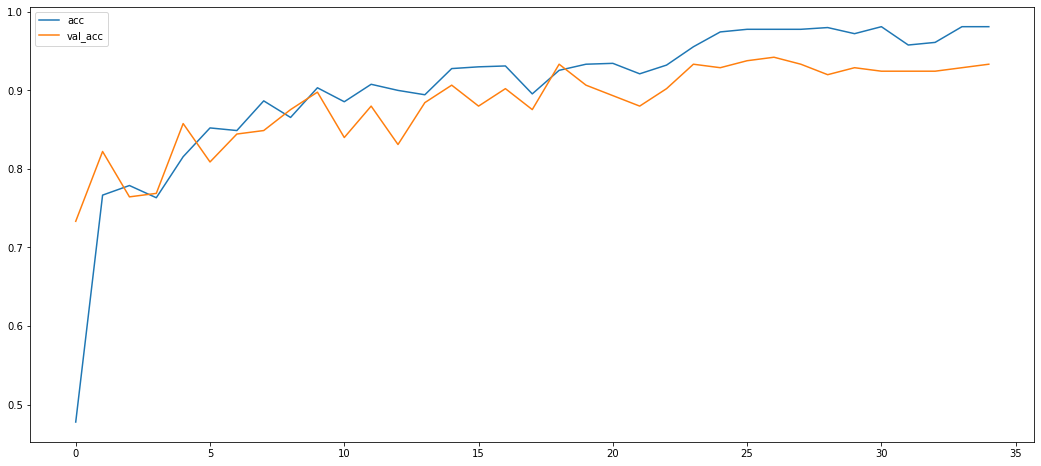

In [54]:
# Train the model, history will allow use to evaluate results
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 128, epochs = 35)


plt.figure(figsize = (18, 8))
#plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

El entrenamiento comenzó con una precisión del 47,78% y una pérdida de 1,2285. Después de la primera epoch, la precisión en el conjunto de validación fue del 73,33% y la pérdida de validación fue de 0,7699. Durante el entrenamiento, la precisión del modelo mejoró gradualmente y la pérdida disminuyó.

La precisión de la validación fue gradualmente alta, con algunas fluctuaciones durante el entrenamiento. Alcanzó un máximo de 93,33% en la época 19, con una pérdida de validación de 0,2527. Después de eso, la precisión de la validación comenzó a disminuir ligeramente y se estabilizó en torno al 90-91 % durante las últimas epochs.

Podemos decir que modelo funcionó bien en el conjunto de validación, con una precisión promedio del 86,22 % y una pérdida promedio de 0,3892. El rendimiento del modelo en el conjunto de entrenamiento fue aún mejor, con una precisión promedio del 92,29 % y una pérdida promedio de 0,2328. Aparentemente se resuelve el sobreajuste, ya que el rendimiento en el conjunto de validación es consistentemente bueno durante todo el entrenamiento. Veremos la matriz de confusión para finalizar este trabajo. (Que llevó mucho tiempo, pero sirvió increíblemente para asimilar los conceptos y es muy entretenido, por lo que podría seguir).

8/8 [==============================] - 0s 17ms/step


<Axes: >

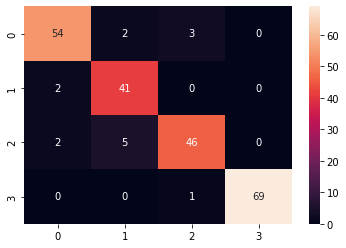

In [55]:
predicted = model.predict(X_test)
predictedClass = [np.argmax(p) for p in predicted]
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = np.argmax(y_test, axis=1)  # Convert MLI format to multiclass format
conf_mat = confusion_matrix(y_true, predictedClass)
sns.heatmap(conf_mat, annot=True)

In [56]:
# Precisión
accuracy = np.trace(conf_mat) / np.sum(conf_mat)

# Sensibilidad
sensitivity = conf_mat.diagonal() / np.sum(conf_mat, axis=1)

# Especificidad
num_classes = conf_mat.shape[0]
tmp_matrix = np.ones((num_classes, num_classes)) - np.eye(num_classes)
specificity = []
for i in range(num_classes):
    tn = np.sum(conf_mat[tmp_matrix[i] == 1])  # True negatives
    fp = np.sum(conf_mat[:, i]) - conf_mat[i, i]  # False positives
    specificity.append(tn / (tn + fp))

# F1-score
beta = 1
f1_score = (1 + beta ** 2) * sensitivity * specificity / (beta ** 2 * specificity + sensitivity)

# Imprimir resultados
print(f"Matriz de confusión:\n{conf_mat}")
print(f"Precisión: {accuracy:.4f}")
print(f"Sensibilidad: {sensitivity}")
print(f"Especificidad: {specificity}")
print(f"F1-score: {f1_score}")

Matriz de confusión:
[[54  2  3  0]
 [ 2 41  0  0]
 [ 2  5 46  0]
 [ 0  0  1 69]]
Precisión: 0.9333
Sensibilidad: [0.91525424 0.95348837 0.86792453 0.98571429]
Especificidad: [0.9764705882352941, 0.9629629629629629, 0.9772727272727273, 1.0]
F1-score: [0.94487193 0.95820225 0.91935859 0.99280576]


En cuanto a la matriz de confusión:
Las filas de la matriz representan las clases predichas de las clases y las columnas representan las verdaderas clases de los asteroides.

Se predijo 54 muestras en la clase 0, 41 en la 1, 46 en la 2 y 69 en la 3. 

Los valores de precisión, sensibilidad, especificidad y F1-score indican que el modelo tiene un rendimiento muy bueno en la tarea de clasificación. Los valores de precisión y F1-score están por encima del 0,9 para todas las clases, lo que indica una buena capacidad de clasificación del modelo. La sensibilidad y especificidad también son bastante altas para todas las clases, el modelo es capaz de identificar correctamente tanto las instancias positivas como las negativas. Podría concluír que el modelo puede ser considerado como un buen clasificador para el conjunto de datos dado.

Olvidaba probar la técnica attention, técnica utilizada para mejorar el rendimiento en diversas tareas. Se basa en la idea de enfocarse selectivamente en ciertas partes de la entrada o representaciones intermedias del modelo, en lugar de procesar toda la entrada de manera uniforme.

En el contexto de las redes neuronales, se puede pensar como un mecanismo que aprende a asignar diferentes pesos a diferentes partes de la entrada o representaciones intermedias, según su relevancia para la tarea en cuestión. Estos pesos se utilizan luego para calcular una suma ponderada de la entrada o las representaciones, que pasa a través de una función de activación no lineal para producir la salida del mecanismo de atención.

Se ha utilizado en varios modelos de deep learning, incluidas las redes neuronales convolucionales (CNN) para la clasificación de imágenes, las redes neuronales recurrentes (RNN) para el procesamiento del lenguaje natural y los modelos de transformadores para la traducción de idiomas y otras tareas de secuencia a secuencia.

A por ello..

### Model 7 - Attention technique

In [117]:
# input layer
inputs = keras.Input(shape=(224, 224, 3))

# convolutional layers
x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(28, kernel_size=(3, 3), activation='relu', padding='same')(x)


# attention mechanism
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='sigmoid')(x)
x = layers.Reshape((1, 1, 64))(x)
x = layers.Conv2D(2, (1, 1), activation='softmax', padding='same')(x)
x = layers.Reshape((2,))(x)

# apply attention mechanism
att1 = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(inputs)
att2 = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(inputs)
x = layers.Multiply()([x, att1, att2])

# flatten layer
x = layers.Flatten()(x)

# dense layers
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(4, activation='softmax')(x)

# define the model
model = keras.Model(inputs=inputs, outputs=outputs)

# print model summary
model.summary()

# compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 224, 224, 16  448         ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_96 (MaxPooling2D  (None, 112, 112, 16  0          ['conv2d_152[0][0]']             
 )                              )                                                           

In [118]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 224, 224, 16  448         ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_96 (MaxPooling2D  (None, 112, 112, 16  0          ['conv2d_152[0][0]']             
 )                              )                                                           

Epoch 1/35
8/8 [==============================] - 7s 228ms/step - loss: 7.1414 - accuracy: 0.2544 - val_loss: 2.4684 - val_accuracy: 0.2356
Epoch 2/35
8/8 [==============================] - 1s 111ms/step - loss: 2.0494 - accuracy: 0.2133 - val_loss: 2.4297 - val_accuracy: 0.2622
Epoch 3/35
8/8 [==============================] - 1s 116ms/step - loss: 1.9300 - accuracy: 0.2233 - val_loss: 1.8426 - val_accuracy: 0.1911
Epoch 4/35
8/8 [==============================] - 1s 118ms/step - loss: 1.5027 - accuracy: 0.2589 - val_loss: 1.4378 - val_accuracy: 0.3111
Epoch 5/35
8/8 [==============================] - 1s 113ms/step - loss: 1.4416 - accuracy: 0.2989 - val_loss: 1.3831 - val_accuracy: 0.3378
Epoch 6/35
8/8 [==============================] - 1s 118ms/step - loss: 1.3874 - accuracy: 0.3256 - val_loss: 1.3942 - val_accuracy: 0.3111
Epoch 7/35
8/8 [==============================] - 1s 115ms/step - loss: 1.4323 - accuracy: 0.3322 - val_loss: 1.3878 - val_accuracy: 0.4178
Epoch 8/35
8/8 [====

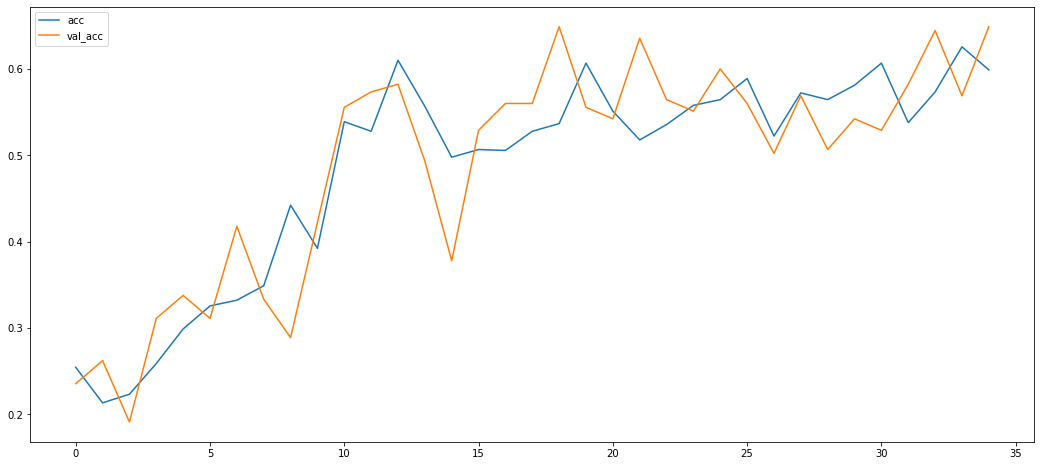

In [119]:
# Train the model, history will allow use to evaluate results
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 128, epochs = 35)


plt.figure(figsize = (18, 8))
#plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

Muy malo el primer entrenamiento. Veremos con el segundo...



Epoch 1/40
2/2 [==============================] - 1s 724ms/step - loss: 0.6377 - accuracy: 0.7689 - val_loss: 0.5804 - val_accuracy: 0.7778
Epoch 2/40
2/2 [==============================] - 1s 472ms/step - loss: 0.6367 - accuracy: 0.7644 - val_loss: 0.5641 - val_accuracy: 0.7467
Epoch 3/40
2/2 [==============================] - 1s 479ms/step - loss: 0.6331 - accuracy: 0.7567 - val_loss: 0.5663 - val_accuracy: 0.7822
Epoch 4/40
2/2 [==============================] - 1s 480ms/step - loss: 0.6317 - accuracy: 0.7733 - val_loss: 0.5539 - val_accuracy: 0.7689
Epoch 5/40
2/2 [==============================] - 1s 478ms/step - loss: 0.6364 - accuracy: 0.7544 - val_loss: 0.5493 - val_accuracy: 0.7822
Epoch 6/40
2/2 [==============================] - 1s 482ms/step - loss: 0.6252 - accuracy: 0.7944 - val_loss: 0.5572 - val_accuracy: 0.7956
Epoch 7/40
2/2 [==============================] - 1s 479ms/step - loss: 0.6305 - accuracy: 0.7600 - val_loss: 0.5479 - val_accuracy: 0.7644
Epoch 8/40
2/2 [====

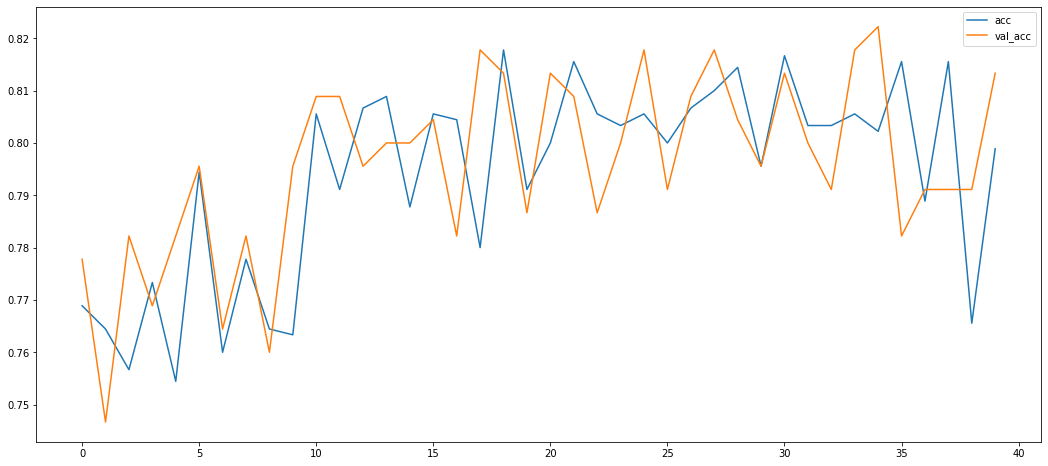

In [121]:
# Train the model, history will allow use to evaluate results
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 512, epochs = 40)


plt.figure(figsize = (18, 8))
#plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

No parece converger, quizás hay que seguir cambiando parámetros en el modelo. 

8/8 [==============================] - 0s 26ms/step


<Axes: >

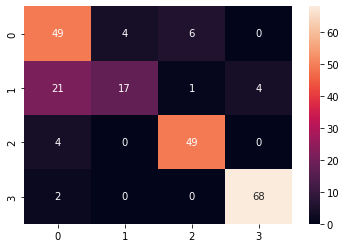

In [122]:
predicted = model.predict(X_test)
predictedClass = [np.argmax(p) for p in predicted]
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = np.argmax(y_test, axis=1)  # Convert MLI format to multiclass format
conf_mat = confusion_matrix(y_true, predictedClass)
sns.heatmap(conf_mat, annot=True)

In [123]:
# Precisión
accuracy = np.trace(conf_mat) / np.sum(conf_mat)

# Sensibilidad
sensitivity = conf_mat.diagonal() / np.sum(conf_mat, axis=1)

# Especificidad
num_classes = conf_mat.shape[0]
tmp_matrix = np.ones((num_classes, num_classes)) - np.eye(num_classes)
specificity = []
for i in range(num_classes):
    tn = np.sum(conf_mat[tmp_matrix[i] == 1])  # True negatives
    fp = np.sum(conf_mat[:, i]) - conf_mat[i, i]  # False positives
    specificity.append(tn / (tn + fp))

# F1-score
beta = 1
f1_score = (1 + beta ** 2) * sensitivity * specificity / (beta ** 2 * specificity + sensitivity)

# Imprimir resultados
print(f"Matriz de confusión:\n{conf_mat}")
print(f"Precisión: {accuracy:.4f}")
print(f"Sensibilidad: {sensitivity}")
print(f"Especificidad: {specificity}")
print(f"F1-score: {f1_score}")

Matriz de confusión:
[[49  4  6  0]
 [21 17  1  4]
 [ 4  0 49  0]
 [ 2  0  0 68]]
Precisión: 0.8133
Sensibilidad: [0.83050847 0.39534884 0.9245283  0.97142857]
Especificidad: [0.8601036269430051, 0.978494623655914, 0.9608938547486033, 0.9748427672955975]
F1-score: [0.84504701 0.56315981 0.94236037 0.97313267]


Parece tener una aceptable precisión, sensibilidad y F1 score. Pero voy a quedarme con el modelo 6.
Seguiría intentando (pero debo seguir con el Trabajo Práctico 3).
A simple vista no parece mejorar con la técnica Attention, quizás hay algo mal en la definción del modelo, pero valió la pena intentarlo y entender su concepto.